**Install the necessary packages required to run this notebook**

The mainly used libraries here are fastai and opencv

In [1]:
!pip install fastai 

In [2]:
!pip install opencv-python

Importing all the required libraries and setting up the fastbook

In [1]:
import cv2
import numpy as np
import time
import fastbook
fastbook.setup_book()

I am using duckduckgo search (DDGS) from fastai to search for urls of our labels

In [2]:
from fastbook import *
from fastai.vision.widgets import *
from fastdownload import download_url
from duckduckgo_search import DDGS

Creating a function to take name of the label and return the searched image url

In [3]:
def search_images(name,max_images):
    print(f"searching for {name}")
    results=(DDGS().images(name,max_results=max_images))
    urls=[item['image'] for item in results]
    return urls

Taking the number of labels and the label input.
In this case I have taken two labels "happy" and "sad"

In [4]:
a = int(input("Number of things you want to classify: "))
labels=[]

if(a<2):
    print("invalid number of labels")
else:
    labels = []

    for i in range(a):
        s = input("What do you want to classify: ")
        labels.append(s)
    

Number of things you want to classify: 2
What do you want to classify: happy
What do you want to classify: sad


In [5]:
labels

['happy', 'sad']

Creating a path to store all the images 

In [6]:
path=Path('my_classifier')

Downloading all the images with extra images of the same label with added nouns such as day and night to include bright and dark photos as well

In [11]:
for img in labels :
    dest=(path/img)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest,urls=search_images(f'{img} person images',100))
    download_images(dest,urls=search_images(f'{img} male images',100))
    download_images(dest,urls=search_images(f'{img} female images',100))
    print(f'downloading all {img} images')
    time.sleep(5)

searching for happy person images
searching for happy male images
searching for happy female images
downloading all happy images
searching for sad person images
searching for sad male images
searching for sad female images
downloading all sad images


Removing the failed images from the path 

In [12]:
failed=verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

26

Making a DataBlock for the labels 

In [13]:
states=DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2,seed=1),
    get_y=parent_label,
    item_tfms=Resize(128)
    )

Images of the validation set

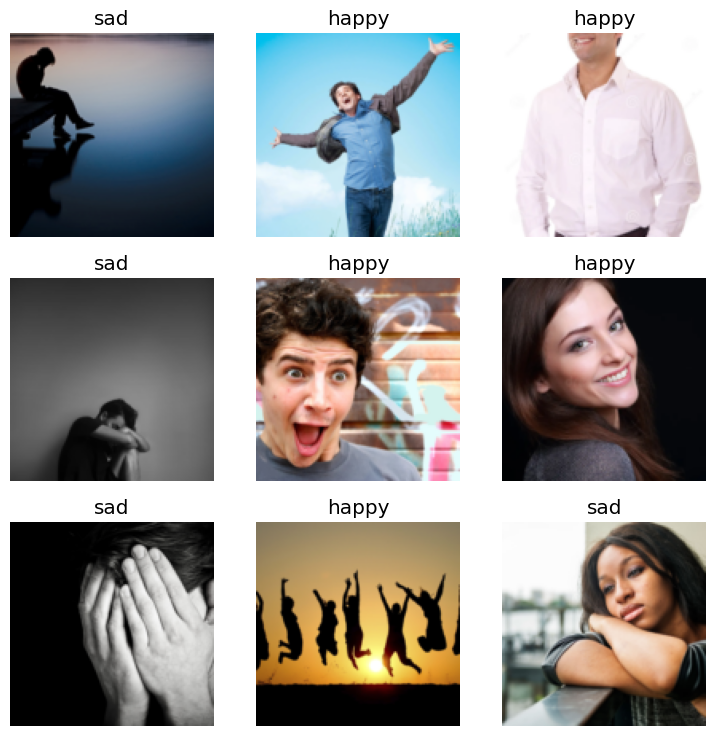

In [14]:
dls=states.dataloaders(path)
dls.valid.show_batch()

**Adding transformations to the training set images**`

Resizing the images

In [15]:
states=states.new(item_tfms=Resize(128, ResizeMethod.Squish))

Cropping the images randomly 

In [16]:
states=states.new(item_tfms=RandomResizedCrop(128, min_scale=0.2))

Using built in data Augmentation in fastai

In [17]:
states=states.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))

Training Set images

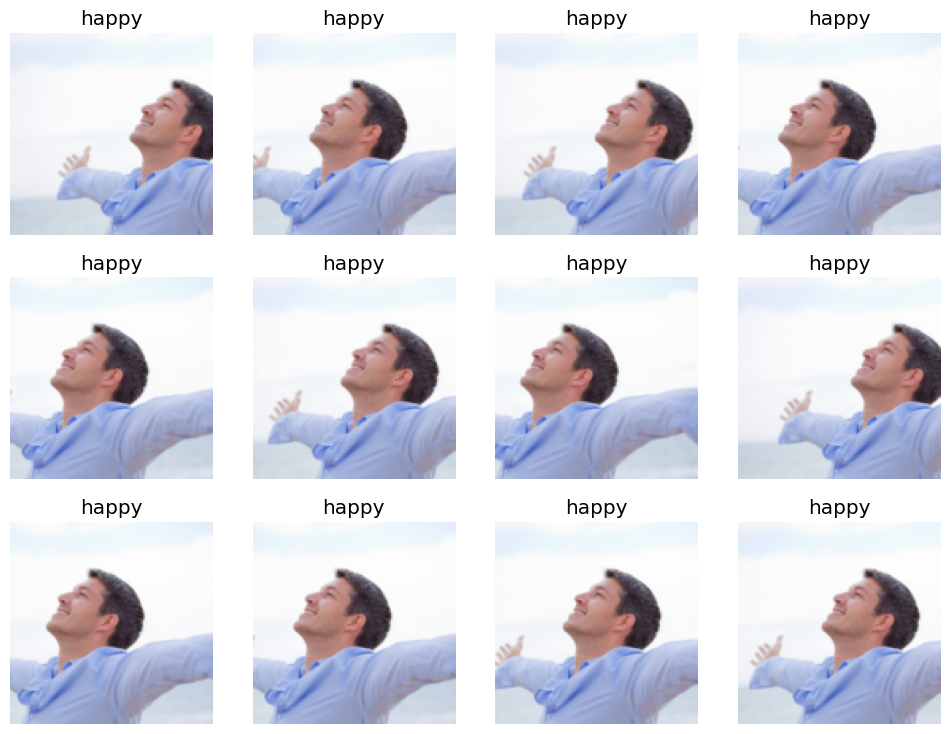

In [18]:
dls.train.show_batch(max_n=12, nrows=3, unique=True)

Loading the model/learner.In this case I am using the Resnet34 and fine tuning it on the training set

In [22]:
learner=vision_learner(dls,resnet34,metrics=error_rate)
learner.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\91637/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100%|█████████████████████████████████████████████████████████████████████████████| 83.3M/83.3M [00:48<00:00, 1.79MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.030476,0.539206,0.201923,00:32


C:\Users\91637\anaconda3\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.478201,0.255672,0.125000,00:36
1,0.339659,0.281202,0.105769,00:36
2,0.266691,0.315816,0.096154,00:37
3,0.217044,0.307975,0.086538,00:37
4,0.189627,0.294955,0.096154,00:37


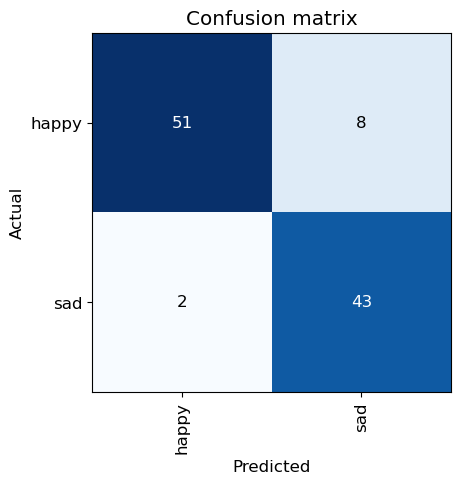

In [23]:
interp=ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

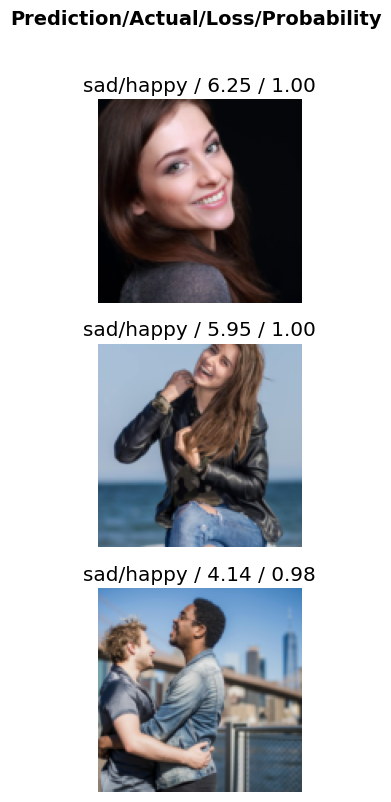

In [24]:
interp.plot_top_losses(3,nrows=3)

For the testing images I decided to use my own images captured from my webcam

For this I have used opencv to capture the images on the command 's' and the images are stored in the same working directory of this notebook

In [33]:
cap = cv2.VideoCapture(0)  # 0 is the default camera
i=0
while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    cv2.imshow("Camera Feed", frame)
    
    key = cv2.waitKey(1) & 0xFF
    if key == ord('x'):  # Exit loop when 'x' is pressed
        break
    elif key == ord('s'):  # Save image when 's' is pressed
        save_path = f"captured_image{i}.jpg"
        cv2.imwrite(save_path, frame)
        print(f"Image saved at {save_path}")
        i+=1


cap.release()
cv2.destroyAllWindows()


Image saved at captured_image0.jpg
Image saved at captured_image1.jpg
Image saved at captured_image2.jpg


In [34]:
label_to_idx = dict([("happy", 0), ("sad", 1)])

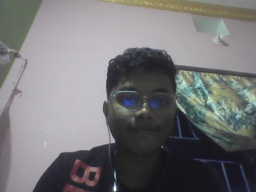

In [35]:
save_path = f"captured_image{1}.jpg"
image=Image.open(save_path)
image.to_thumb(256,256)

In [36]:
curr_state,_,prob=learner.predict(PILImage.create(save_path))
print(f"the current state is {curr_state} with a probabilty of {prob[label_to_idx[curr_state]]}")

the current state is sad with a probabilty of 0.9114303588867188


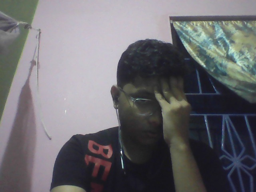

In [37]:
save_path = f"captured_image{0}.jpg"
image=Image.open(save_path)
image.to_thumb(256,256)

In [38]:
curr_state,_,prob=learner.predict(PILImage.create(save_path))
print(f"the current state is {curr_state} with a probabilty of {prob[label_to_idx[curr_state]]}")

the current state is sad with a probabilty of 0.9527953267097473


Exporting the Model

In [39]:
learner.export()
path=Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]